In [25]:
import os
import zipfile
import datetime
from collections import Counter

import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Add, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy

import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import pydot
from tensorflow.python.client import device_lib
import pathlib
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import random
import importlib

In [26]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [27]:
"""Data Augmentation"""
train_data_gen = ImageDataGenerator(rescale=1./255 ,
                                    zoom_range= 0.3, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    rotation_range = 30
                                    )

train = train_data_gen.flow_from_directory(directory= '../inception_resnetv2/Data/Train',
                                           class_mode = 'binary',
                                           batch_size=20,
                                           target_size=(299,299))

Found 11047 images belonging to 2 classes.


In [28]:
test_data_gen = ImageDataGenerator(rescale=1./255 )

test = test_data_gen.flow_from_directory(directory= '../inception_resnetv2/Data/Test' , 
                                          target_size=(299,299), 
                                            class_mode = 'binary',
                                        shuffle=False,
                                        batch_size=20)

valid = test_data_gen.flow_from_directory(directory= '../inception_resnetv2/Data/Valid' , 
                                          target_size=(299,299), 
                                            class_mode = 'binary',
                                        shuffle=False,
                                        batch_size=20)

Found 1377 images belonging to 2 classes.
Found 1384 images belonging to 2 classes.


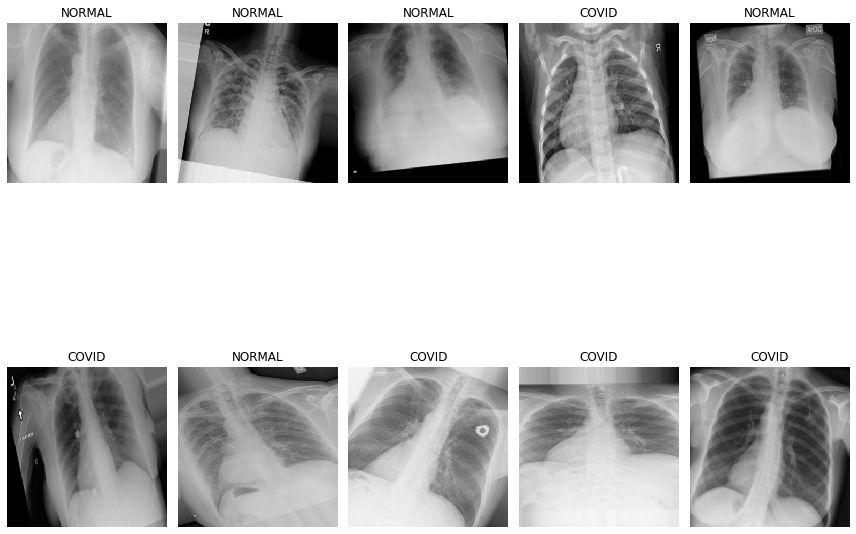

In [29]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'COVID'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [30]:
basenet1 = tf.keras.applications.xception.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3) 
)

In [31]:
for layer in basenet1.layers:           
    layer.trainable = False

In [32]:
x = Flatten()(basenet1.output)
d1 = Dense(512, activation= 'relu')(x)
dr1 = Dropout(0.25)(d1)
d2 = Dense(512, activation= 'relu')(dr1)
dr2 = Dropout(0.25)(d2)
prediction= Dense(units=1 , activation='sigmoid')(dr2)

model = Model(basenet1.input,prediction)

In [33]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [34]:
early = EarlyStopping(monitor='val_accuracy', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [35]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9092637400622192, 1: 0.6773975962717684}


In [36]:
hist = model.fit(train, steps_per_epoch= len(train), epochs= 50, validation_data= valid,class_weight=cw,validation_steps= len(test), callbacks=callbacks_list)

Epoch 1/50
553/553 [==============================] - 518s 933ms/step - loss: 1.0140 - accuracy: 0.7857 - val_loss: 0.3735 - val_accuracy: 0.8659
Epoch 2/50
553/553 [==============================] - 530s 957ms/step - loss: 0.4423 - accuracy: 0.8485 - val_loss: 0.2955 - val_accuracy: 0.8696
Epoch 3/50
553/553 [==============================] - 483s 872ms/step - loss: 0.3846 - accuracy: 0.8704 - val_loss: 0.2678 - val_accuracy: 0.9065
Epoch 4/50
553/553 [==============================] - 474s 857ms/step - loss: 0.3828 - accuracy: 0.8716 - val_loss: 0.2543 - val_accuracy: 0.9116


In [37]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

69/69 [==============================] - 49s 709ms/step - loss: 0.2538 - accuracy: 0.9129
The testing accuracy is : 91.2854015827179 %


In [38]:
#model2.save('xception_normal_covid')

In [39]:
preds = model.predict(test,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

69/69 [==============================] - 46s 663ms/step


<AxesSubplot:>

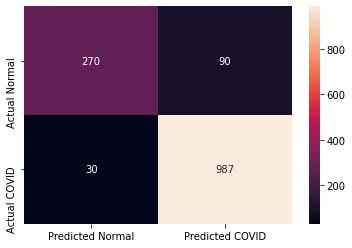

In [40]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual COVID"],
columns=["Predicted Normal", "Predicted COVID"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [41]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','COVID']))

              precision    recall  f1-score   support

      NORMAL       0.90      0.75      0.82       360
       COVID       0.92      0.97      0.94      1017

    accuracy                           0.91      1377
   macro avg       0.91      0.86      0.88      1377
weighted avg       0.91      0.91      0.91      1377



In [42]:
y_true=test.classes

In [43]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

**Overall Results**
Accuracy Result: 91.29%
Precision Result: 91.64%
Recall Result: 97.05%
F-Score Result: 94.27%


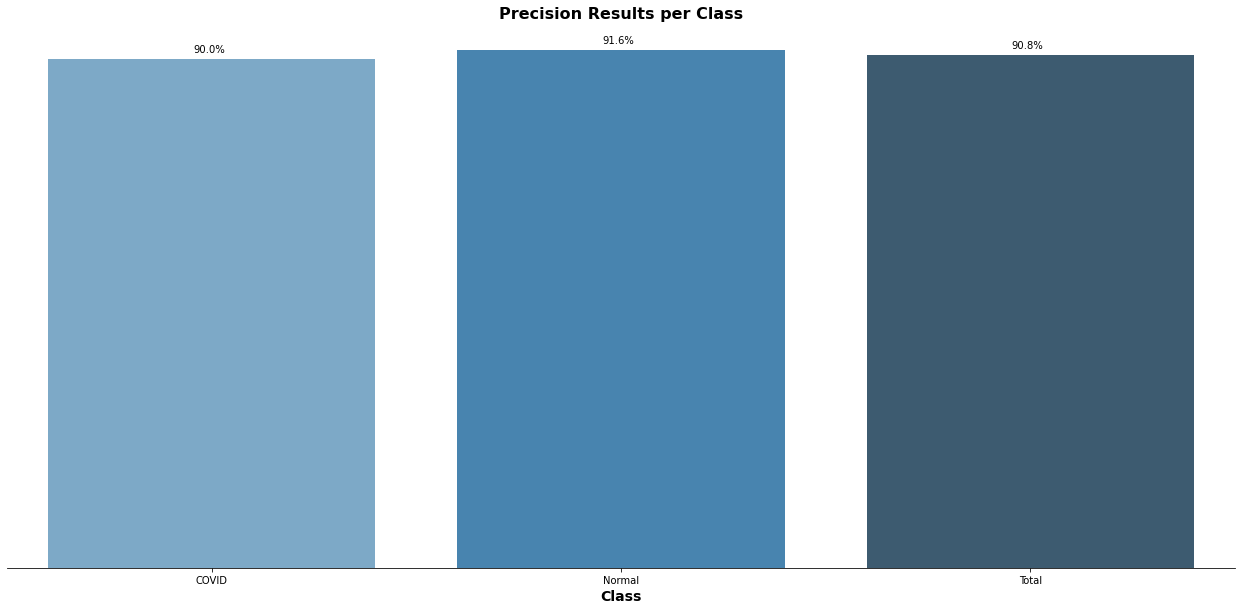

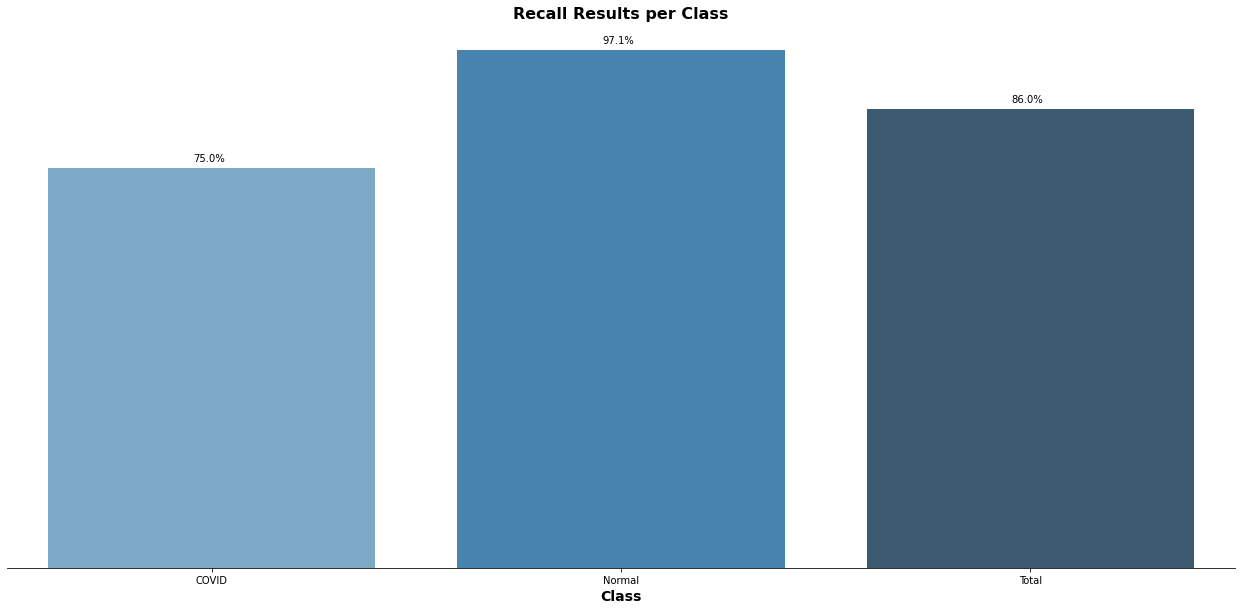

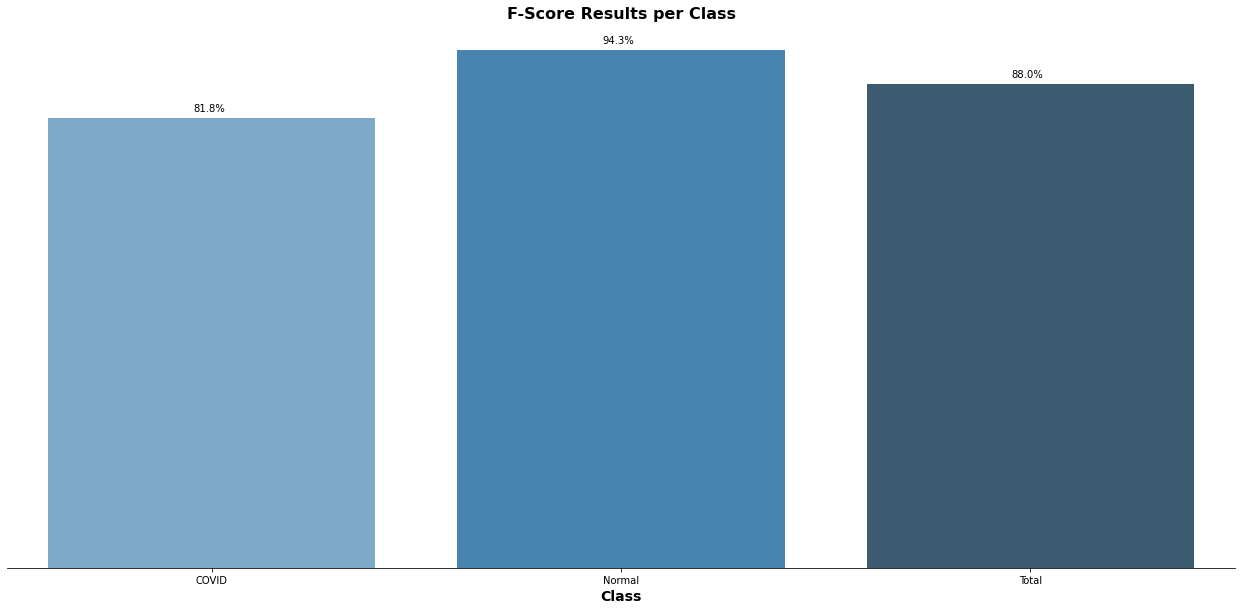

In [44]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID','Normal','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[1,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[1,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[1,2]*100))#F-Score of the whole Dataset

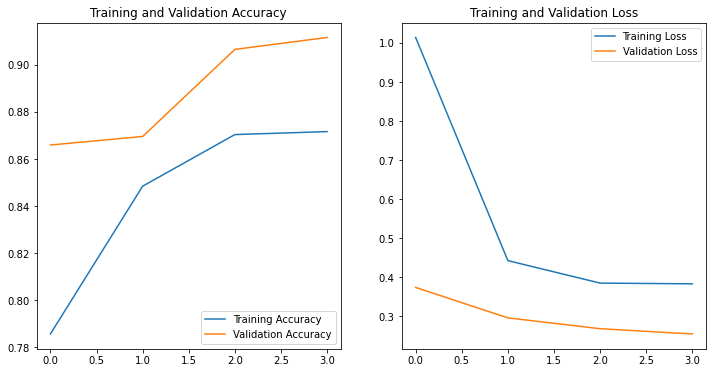

In [46]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(4)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()